In [6]:
import wmi
import psutil
import pandas as pd
import datetime
import time
import random

#  Generating the 1GB **synthetic multivariate time-series data**

In [22]:
# Settings
duration_minutes = 1452      # It will take approximately a whole day to run (so as to obtain data of 1gb)
sampling_rate_hz = 100     # Samples per second 
num_samples = duration_minutes * 60 * sampling_rate_hz
print(f"Total samples to collect: {num_samples}")

# Start time
start_time = datetime.datetime.now()

# Initialize WMI client
w = wmi.WMI(namespace="root\\OpenHardwareMonitor")


Total samples to collect: 8712000


## The code will take a very long time to run! (About a day)

In [8]:
# Initialize lists to store data
timestamps = []
cpu_temperatures = []
cpu_usages = []
cpu_loads = []
memory_usages = []
battery_levels = []
cpu_powers = []

# Collect data
for i in range(num_samples):
    try:
        # Get current time
        current_time = datetime.datetime.now()
        timestamps.append(current_time)
    
        # Get CPU temperature 
        sensor_info = w.Sensor()
        cpu_temp = None
        cpu_power = None
    
        for sensor in sensor_info:
            if sensor.SensorType == 'Temperature' and 'CPU Package' in sensor.Name:         # Changed CPU to CPU package ( adjusted it to fit my laptop)
                cpu_temp = sensor.Value
            
            if sensor.SensorType == 'Power' and 'CPU Package' in sensor.Name:               # That is what we will use for the cpu_power
                cpu_power = sensor.Value
                cpu_powers.append(cpu_power)
                cpu_temperatures.append(cpu_temp)

        # Get CPU usage
        cpu_usage = psutil.cpu_percent(interval=1/sampling_rate_hz)
        cpu_usages.append(cpu_usage)
    
        # Get CPU load (1 minute average)
        cpu_load = psutil.getloadavg()[0]
        cpu_loads.append(cpu_load)
    
        # Get memory usage
        memory_usage = psutil.virtual_memory().percent
        memory_usages.append(memory_usage)

        # Get battery level
        battery = psutil.sensors_battery()
        battery_level = battery.percent if battery else None
        battery_levels.append(battery_level)

        # Introduce anomalies randomly (e.g., 10% chance)                      
        if random.random() < 0.1: # 10% chance to introduce anomaly
            # Introduce high CPU usage
            cpu_usages[-1] = random.uniform(90, 100) # High CPU usage (Random value between 90% and 100%)
        
        if random.random() < 0.1:
            # Introduce high temperature
            cpu_temperatures[-1] = random.uniform(90, 105) # High Temperature (Random value between 90°C and 105°C)
        
        if random.random() < 0.1:
            # Introduce high memory usage
            memory_usages[-1] = random.uniform(92, 100) # High memory Usage (Random value between 92% and 100%)

        if random.random() < 0.1:
            # Introduce low battery level
            battery_levels[-1] = random.uniform(0, 10) # Low Battery level (Random value between 0% and 10%)

        if random.random() < 0.1:
            # Introduce high CPU power
            cpu_powers[-1] = random.uniform(70, 100) # Unusually high CPU power (Random value between 70W and 100W)


    except Exception as e:
        print(f"Error collecting data: {e}")
        cpu_temperatures.append(None)
        cpu_usages.append(None)
        cpu_loads.append(None)
        memory_usages.append(None)
        battery_levels.append(None)
        cpu_powers.append(None)



- I adjusted the anomalies range to be more realistic for my laptop.

In [15]:
# Create DataFrame
data = {
'timestamp': timestamps,
'cpu_temperature': cpu_temperatures,
'cpu_usage': cpu_usages,
'cpu_load': cpu_loads,
'memory_usage': memory_usages,
'battery_level': battery_levels,
'cpu_power': cpu_powers
}

In [16]:
df_real = pd.DataFrame(data)

In [17]:
# Save to CSV in append mode
df_real.to_csv(r'C:\Users\oshev\OneDrive\Desktop\JYP\hardware_monitor_data.csv', mode='a', index=False)

In [18]:
# Wait for the next sample
time.sleep(1 / sampling_rate_hz)

In [19]:
df_real.head()

,timestamp,cpu_temperature,cpu_usage,cpu_load,memory_usage,battery_level,cpu_power
0,2024-11-27 10:08:57.366768,102.292258,25.000000,0.01,96.966813,94.0,0.612932
1,2024-11-27 10:08:58.541884,NaN,18.700000,0.01,64.200000,94.0,4.398841
2,2024-11-27 10:08:59.671553,NaN,21.100000,0.01,64.100000,94.0,1.309238
3,2024-11-27 10:09:00.820723,NaN,18.600000,0.09,64.100000,94.0,1.883050
4,2024-11-27 10:09:01.962128,NaN,98.240339,0.09,64.100000,94.0,83.971291


## Loading the dataset (hardware_monitor_data)

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
data = pd.read_csv('hardware_monitor_data.csv')
data

,timestamp,cpu_temperature,cpu_usage,cpu_load,memory_usage,battery_level,cpu_power
0,2024-11-27 10:08:57.366768,102.317952,26.353055,0.009221,96.992934,94.207495,0.297203
1,2024-11-27 10:08:58.366768,NaN,19.050392,0.340000,95.393652,93.779661,4.366451
2,2024-11-27 10:08:59.366768,NaN,21.140912,0.300000,63.962152,94.472123,0.820048
3,2024-11-27 10:09:00.366768,NaN,18.113610,0.090920,64.137293,6.489734,1.461135
4,2024-11-27 10:09:01.366768,NaN,99.101723,0.089469,96.623042,94.066406,83.768154
...,...,...,...,...,...,...,...
8711995,2024-11-28 06:08:52.366768,NaN,0.686934,0.250029,57.759200,53.765660,84.195342
8711996,2024-11-28 06:08:53.366768,NaN,1.953248,0.009965,93.631772,53.723644,90.845841
8711997,2024-11-28 06:08:54.366768,NaN,4.696356,0.010491,58.072058,53.834613,80.733148
8711998,2024-11-28 06:08:55.366768,NaN,0.554798,0.009531,57.649071,53.344093,89.449683


## To check missing values

In [29]:
data.isnull().sum()

timestamp                0
cpu_temperature    7808130
cpu_usage                0
cpu_load                 0
memory_usage             0
battery_level            0
cpu_power                0
dtype: int64

## 'cpu_temperature' column has alot of missing values so I will drop the column

In [30]:
data.drop('cpu_temperature', axis = 1, inplace = True)

In [31]:
data.head()

,timestamp,cpu_usage,cpu_load,memory_usage,battery_level,cpu_power
0,2024-11-27 10:08:57.366768,26.353055,0.009221,96.992934,94.207495,0.297203
1,2024-11-27 10:08:58.366768,19.050392,0.340000,95.393652,93.779661,4.366451
2,2024-11-27 10:08:59.366768,21.140912,0.300000,63.962152,94.472123,0.820048
3,2024-11-27 10:09:00.366768,18.113610,0.090920,64.137293,6.489734,1.461135
4,2024-11-27 10:09:01.366768,99.101723,0.089469,96.623042,94.066406,83.768154


# Applying an anomaly detection algorithm
## I will make use of **Z-Score** :
### it subtracts the 'average value' in a column from a 'single value' and divides the absolute result by the 'standard deviation' 

In [37]:
# Function to calculate Z-scores and detect anomalies
def detect_anomalies(data_v, column, threshold=2.1):
    
    mean = data_v[column].mean()
    std = data_v[column].std()
    data_v[f'{column}_zscore'] = (data_v[column] - mean) / std
    data_v[f'{column}_anomaly'] = data_v[f'{column}_zscore'].abs() > threshold
    return data_v

# Applying anomaly detection on key columns
columns_to_analyze = ['cpu_usage', 'cpu_load', 'memory_usage', 'battery_level', 'cpu_power']
threshold = 2.1  # Z-score threshold
for col in columns_to_analyze:
    data = detect_anomalies(data, col, threshold)

# To Count anomalies
for col in columns_to_analyze:
    anomaly_count = data[f'{col}_anomaly'].sum()
    print(f"{col}: {anomaly_count} anomalies detected.")

cpu_usage: 186557 anomalies detected.
cpu_load: 409745 anomalies detected.
memory_usage: 713536 anomalies detected.
battery_level: 0 anomalies detected.
cpu_power: 718400 anomalies detected.


- The anomalies are less than 10% of the whole data
- N/B: There was no anomaly in battery level because my laptop kept reaching the (0-20) range alot so it was calculated as part of the normal value.

# Visualling the Data (indicating the anomalies in each dataset)

C:\Users\oshev\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


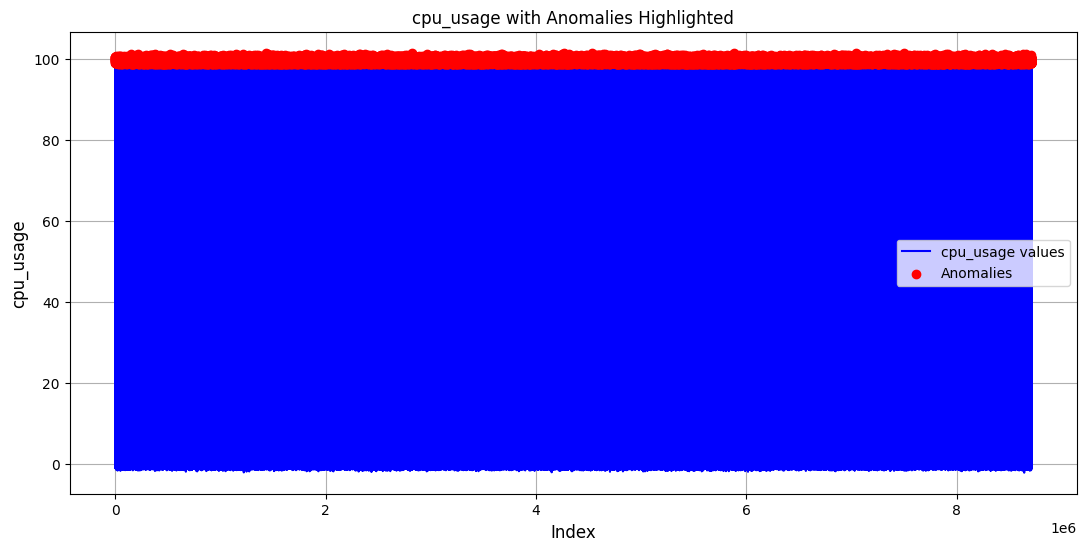

C:\Users\oshev\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


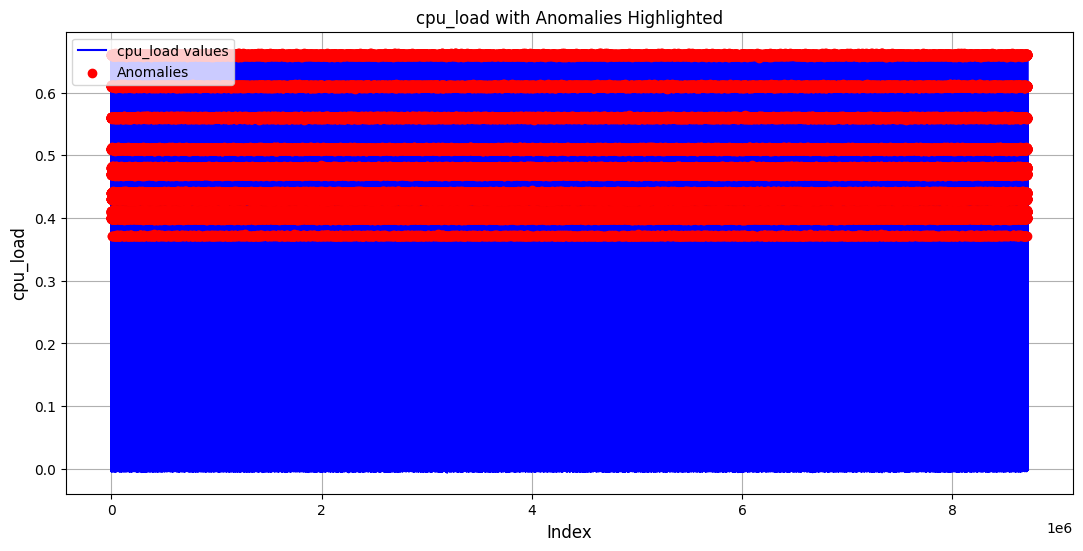

C:\Users\oshev\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


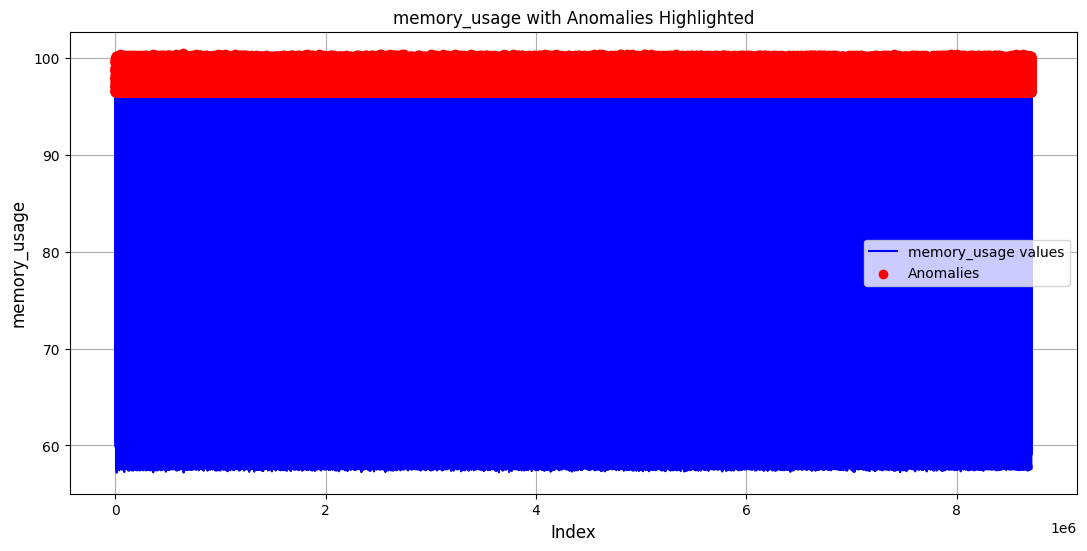

C:\Users\oshev\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


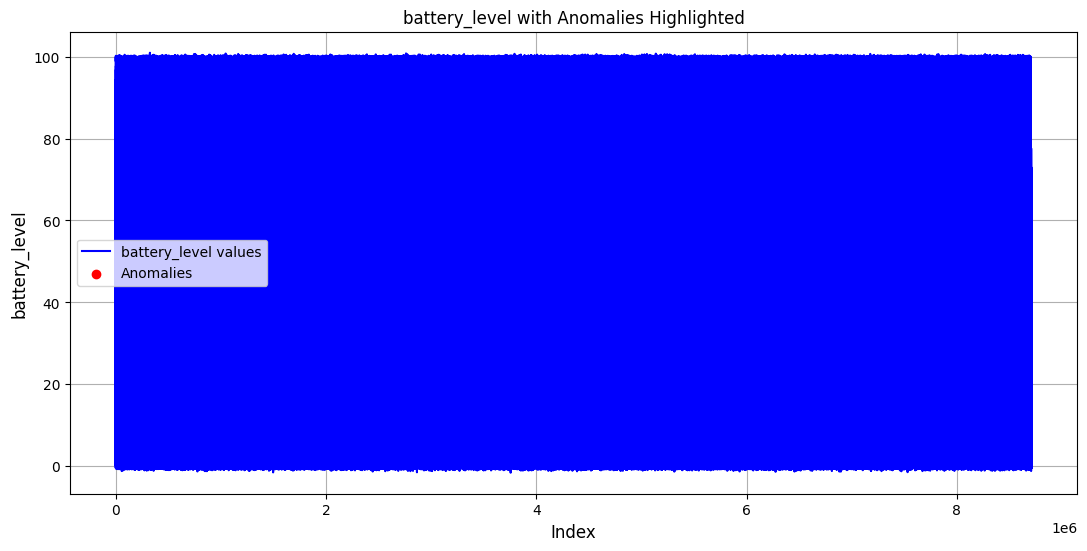

C:\Users\oshev\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


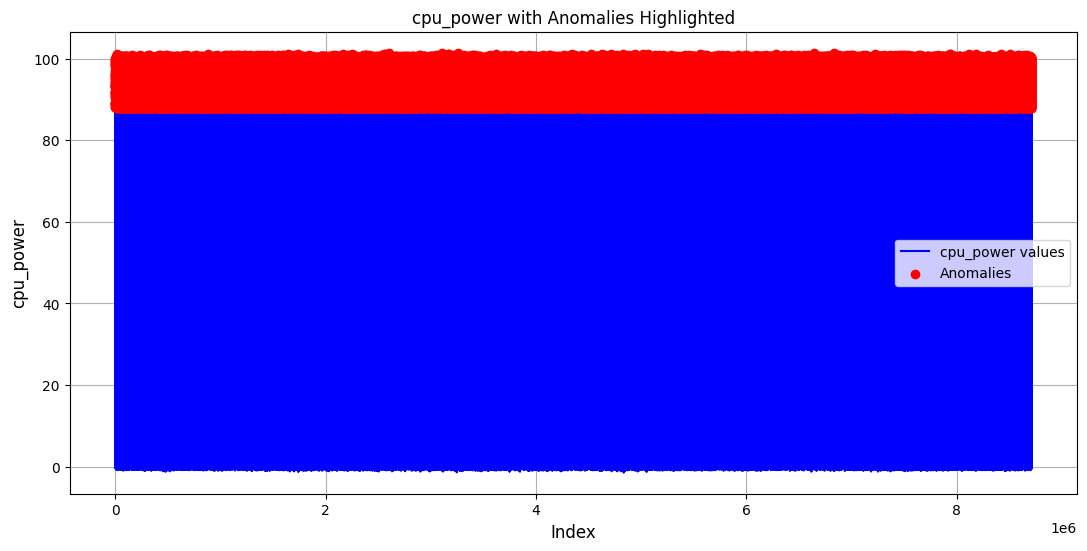

In [39]:
# Function to visualize data and highlight anomalies.
def plot_anomalies(data_v, column):
   
    plt.figure(figsize=(13, 6))
    sns.lineplot(x=data_v.index, y=data_v[column], label=f"{column} values", color='blue')
    # Highlight anomalies
    anomalies = data_v[data_v[f'{column}_anomaly']]
    plt.scatter(anomalies.index, anomalies[column], color='red', label='Anomalies', zorder=5)
    plt.title(f"{column} with Anomalies Highlighted")
    plt.xlabel("Index", fontsize = 12)
    plt.ylabel(column, fontsize = 12)
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize each column
for col in columns_to_analyze:
    plot_anomalies(data, col)